## Homework 2
## Practice Linear Regression and Hyperparameter Search


This assignment is aimed to help you get more experience with [linear models](https://scikit-learn.org/stable/modules/linear_model.html) (especially linear regression) and [hyperparameter search](https://scikit-learn.org/stable/model_selection.html) in scikit-learn library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Today's data

400 fotos of human faces. Each face is a 2d array [64x64] of pixel brightness.

In [2]:
from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces().images

Let's see some faces

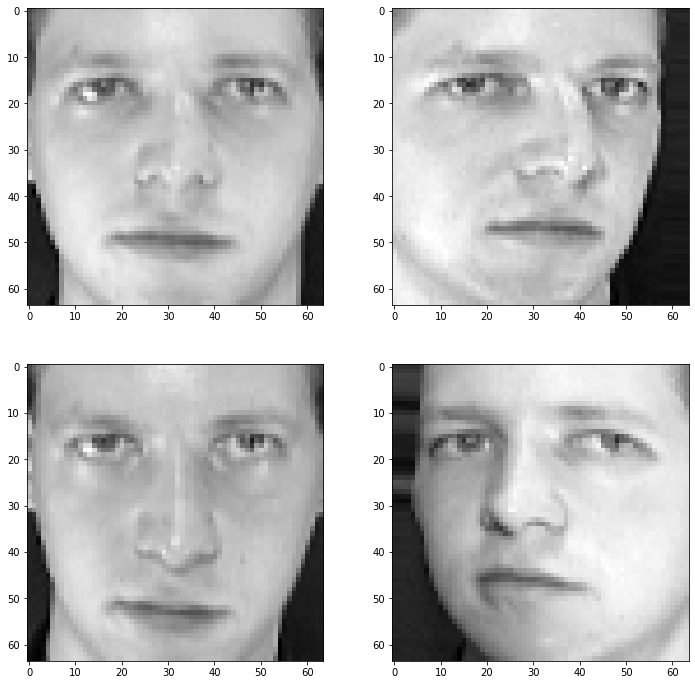

In [3]:
# this code showcases matplotlib subplots.
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.flatten()

for i in range(4):
    ax[i].imshow(data[i],cmap='gray')

plt.show()

# Face reconstruction problem

Let's solve the face reconstruction problem: given left halves of facex __(X)__, our algorithm shall predict the right half __(y)__. The idea of this approach is that left face half actually contains quite enough information to reconstruct the right face half (at least partially). Moreover in this task we'll also see, that scikit-learn linear models are capable of predicting multiple targets for a single object example.

Our first step is to slice the photos into X and y using slices.
__Slices in numpy:__
* In regular python, slice looks roughly like this: `a[2:5]` _(select elements from 2 to 5)_
* Numpy allows you to slice N-dimensional arrays along each dimension: [image_index, height, width]
  * `data[:10]` - Select first 10 images
  * `data[:, :10]` - For all images, select a horizontal stripe 10 pixels high at the top of the image
  * `data[10:20, :, -25:-15]` - Take images [10, 11, ..., 19], for each image select a _vetrical stripe_ of width 10 pixels, 15 pixels away from the _right_ side.

__Your task:__

Let's use slices to select all __left image halves as X__ and all __right halves as y__.

In [4]:
# select left half of each face as X, right half as Y
X = data[:, :, :32]
y = data[:, :, 32:]

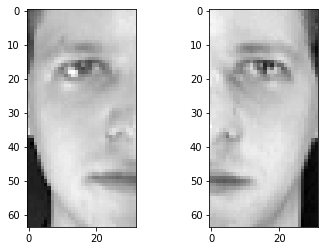

In [5]:
# If you did everything right, you're gonna see left half-image and right half-image drawn separately in natural order
plt.subplot(1,2,1)
plt.imshow(X[0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(y[0],cmap='gray')

assert X.shape == y.shape == (len(data), 64, 32), "Please slice exactly the left half-face to X and right half-face to Y"

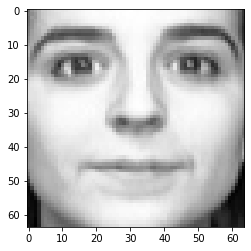

In [6]:
def glue(left_half,right_half):
    # merge photos back together
    left_half = left_half.reshape([-1, 64, 32])
    right_half = right_half.reshape([-1, 64, 32])
    return np.concatenate([left_half, right_half],axis=-1)


# if you did everything right, you're gonna see a valid face
plt.imshow(glue(X, y)[99], cmap='gray')

# Machine learning stuff

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.reshape([len(X), -1]),
                                                    y.reshape([len(y), -1]),
                                                    test_size=0.05, random_state=42)

print(X_test.shape)

(20, 2048)


In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

measure [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error):

$$MSE(\widehat{\theta}) = \mathbf{E}_{\theta}[(\theta - \widehat{\theta})^2] $$

In [9]:
from sklearn.metrics import mean_squared_error
mse_train = mean_squared_error(y_train, model.predict(X_train))
mse_test = mean_squared_error(y_test, model.predict(X_test))

print(f"Train MSE: {mse_train:.5f}")
print(f"Test MSE: {mse_test:.5f}")

Train MSE: 0.00000
Test MSE: 0.01028


---

## Why train error is much smaller than test?

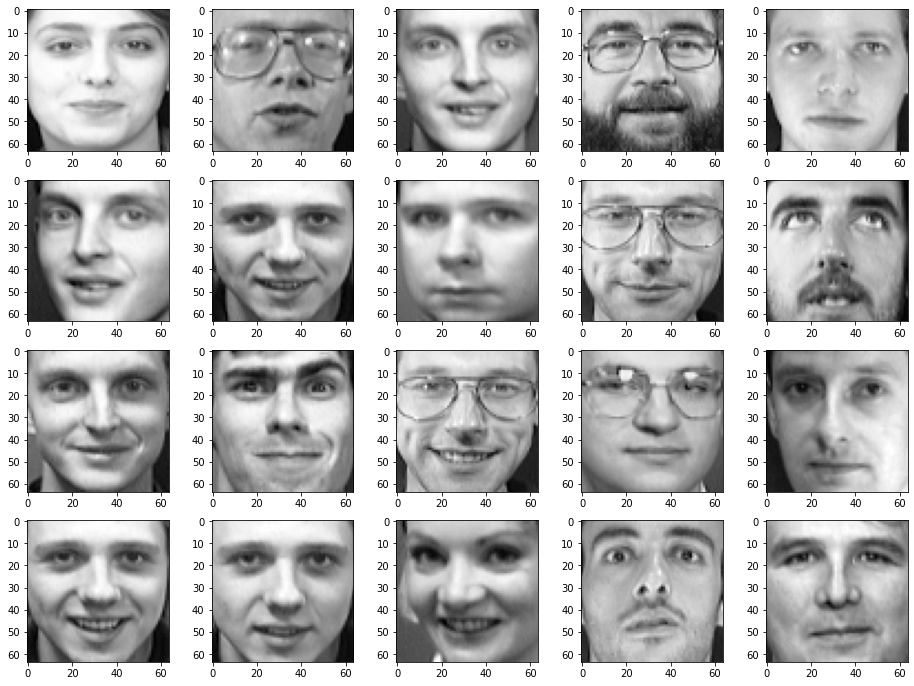

In [10]:
# Train predictions
pics = glue(X_train, model.predict(X_train)) # reconstruct and glue together X and Y for the train dataset
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

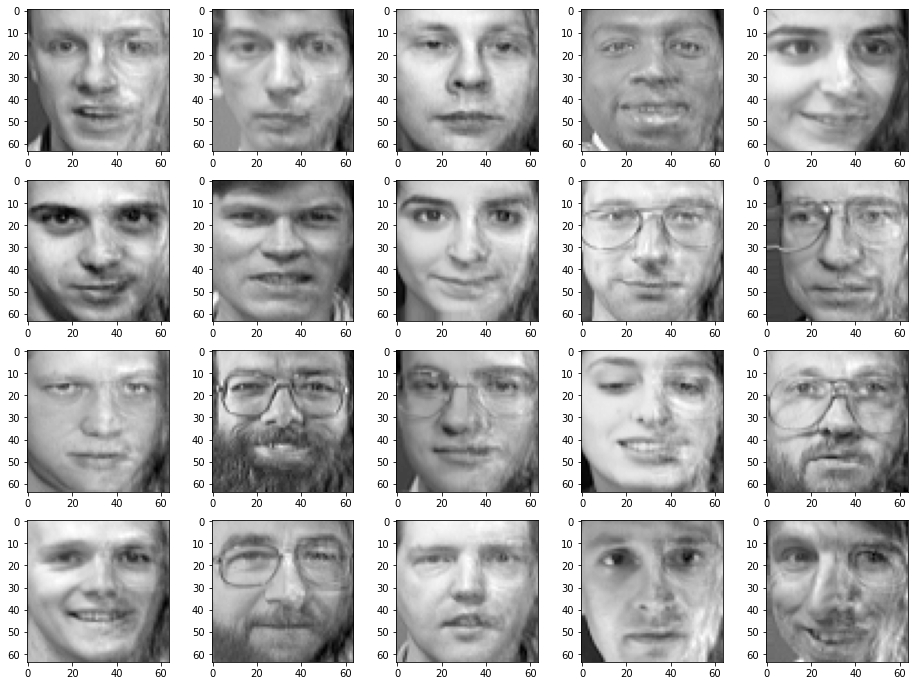

In [11]:
# Test predictions
pics = glue(X_test, model.predict(X_test)) # reconstruct and glue together X and Y for the test dataset
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

Remember regularisation? That is exactly what we need. There are many many linear models in sklearn package, and all of them can be found [here](https://scikit-learn.org/stable/modules/linear_model.html). We will focus on 3 of them: Ridge regression, Lasso and ElasticNet.
Idea of all of them is very simple: Add some penalty to the objective loss function to prevent overfitting.

# Ridge regression
[RidgeRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) is just a LinearRegression, with l2 regularization - penalized for $ \alpha \cdot \sum _i w_i^2$

Let's train such a model with alpha=0.5

In [12]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

Ridge(alpha=0.5)

In [13]:
mse_train = mean_squared_error(y_train, ridge.predict(X_train))
mse_test = mean_squared_error(y_test, ridge.predict(X_test))

print(f"Train MSE: {mse_train:.5f}")
print(f"Test MSE: {mse_test:.5f}")

Train MSE: 0.00042
Test MSE: 0.00803


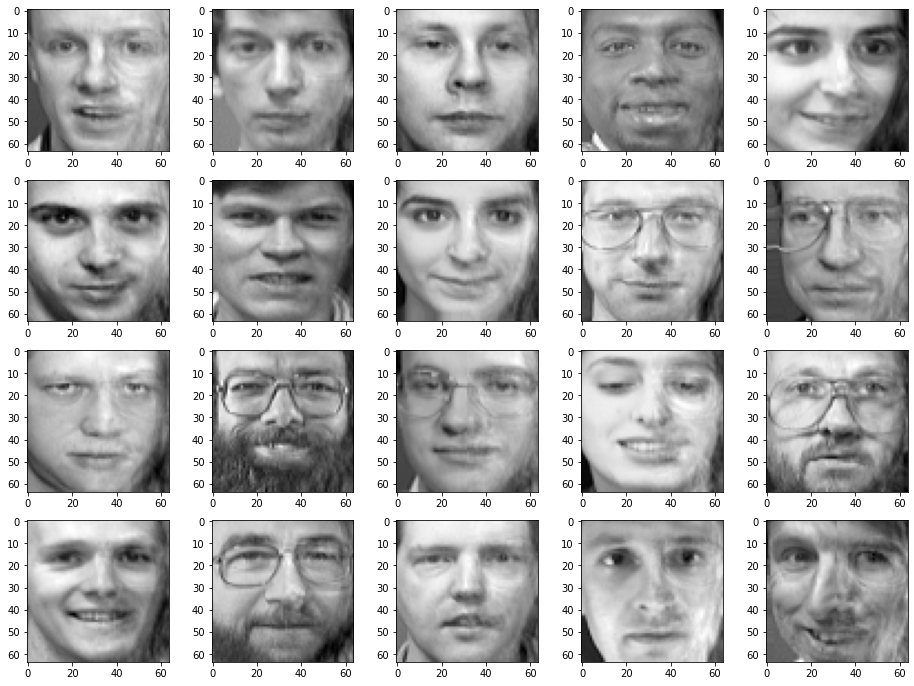

In [14]:
# Test predictions
pics = glue(X_test, ridge.predict(X_test)) # reconstruct and glue together X and Y for the test dataset
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

---

# Grid search

Train model with diferent $\alpha$ and find one that has minimal test MSE. It's okay to use loops or any other python stuff here.

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
def train_and_plot(model, parameter_dict):
    """This function takes a model and parameters
    dict as input and plot a graph of MSE loss VS parameter value"""
    # use GridSearchCV as before to do grid search
    gscv = GridSearchCV(estimator=model,
                        param_grid=parameter_dict,
                        n_jobs=-1)
    gscv.fit(X_train, y_train)
    plt.errorbar(gscv.param_grid['alpha'],
                 gscv.cv_results_['mean_test_score'],
                 gscv.cv_results_['std_test_score'],
                 capsize=5, label=model.__str__().split("(")[0])
    plt.xscale("log", nonposx='clip')
    plt.xlabel("alpha")
    plt.ylabel("negative MSE")
    plt.grid()
    plt.legend()
    return gscv

## Ridge

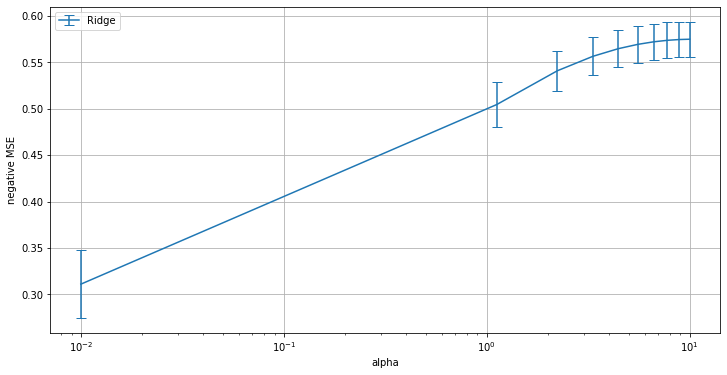

In [17]:
plt.figure(figsize=(12, 6))

models = Ridge() # Start from Ridge regression, but feel free to add 
                     # Lasso and ElasticNet. Note that the latter two cannot
                     # be solved analytically and typically are much slower
                     # to fit than Ridge regression (so you may want to limit
                     # the number of grid points).
parameter_dict = {'alpha': np.linspace(0.01, 10, 10)}

gscv_ridge = train_and_plot(models, parameter_dict)

In [18]:
mean_squared_error(y_test, gscv_ridge.predict(X_test))

0.0074274773

In [19]:
gscv_ridge.best_params_

{'alpha': 10.0}

---

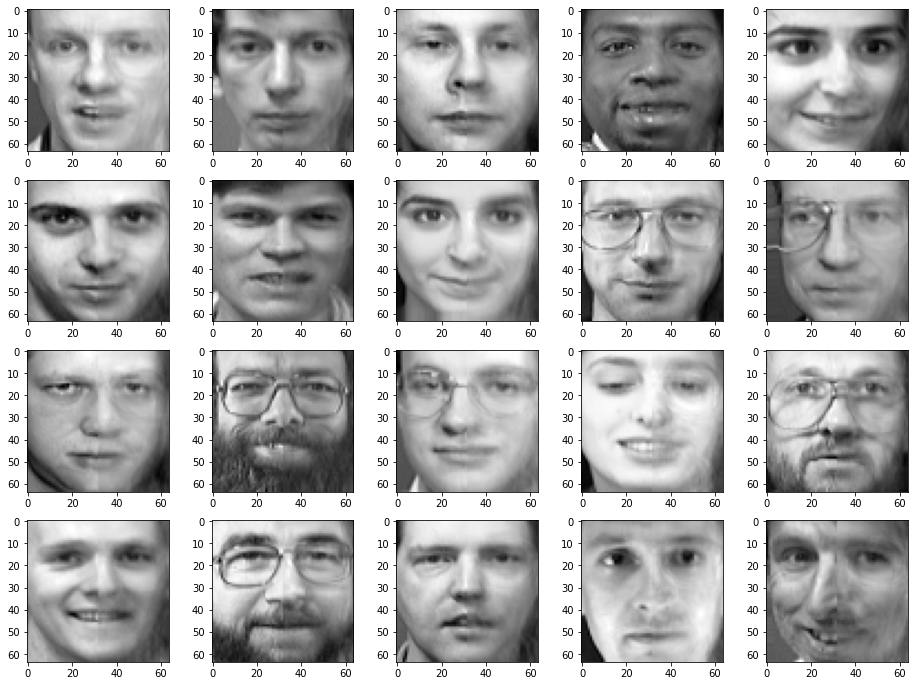

In [20]:
# Test predictions
pics = glue(X_test, gscv_ridge.predict(X_test))
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

---

## Lasso

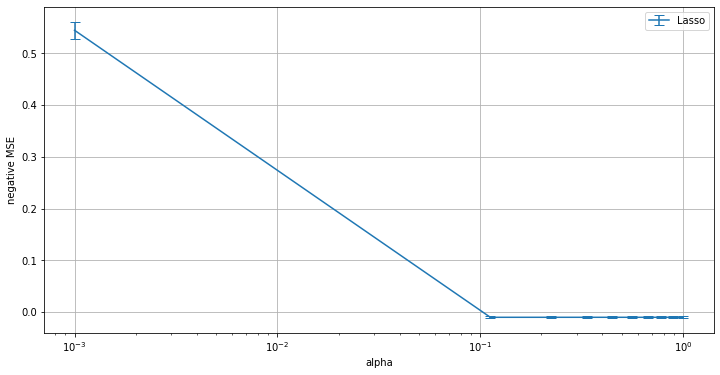

In [21]:
from sklearn.linear_model import Lasso, ElasticNet

# Use the code you have just done to do GridSearch for Lasso and/or ElasticNet
# models (if you haven't already). Note that Lasso and ElasticNet are much
# slower to fit, compared to Ridge.
plt.figure(figsize=(12, 6))
models = Lasso()
parameter_dict = {'alpha': np.linspace(1, 0.001, 10)}
gscv_lasso = train_and_plot(models, parameter_dict)

In [22]:
mean_squared_error(y_test, gscv_lasso.predict(X_test))

0.009721752

In [23]:
gscv_lasso.best_params_

{'alpha': 0.001}

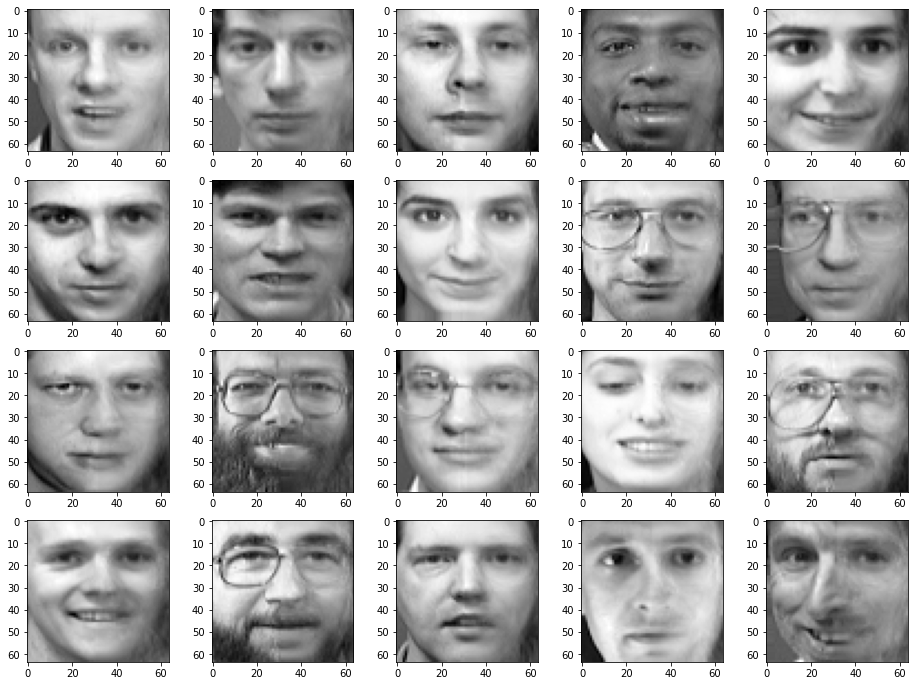

In [24]:
# Test predictions
pics = glue(X_test, gscv_lasso.predict(X_test))
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

---

## ElasticNet

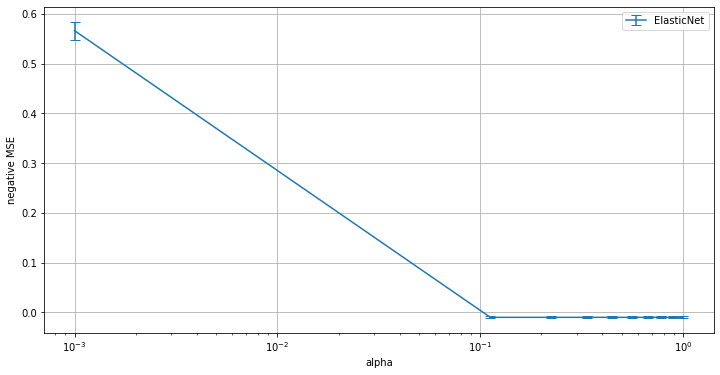

In [25]:
plt.figure(figsize=(12, 6))
models = ElasticNet()
parameter_dict = {'alpha': np.linspace(1, 0.001, 10)}
gscv_elastic = train_and_plot(models, parameter_dict)

In [26]:
mean_squared_error(y_test, gscv_elastic.predict(X_test))

0.008150594

In [27]:
gscv_elastic.best_params_

{'alpha': 0.001}

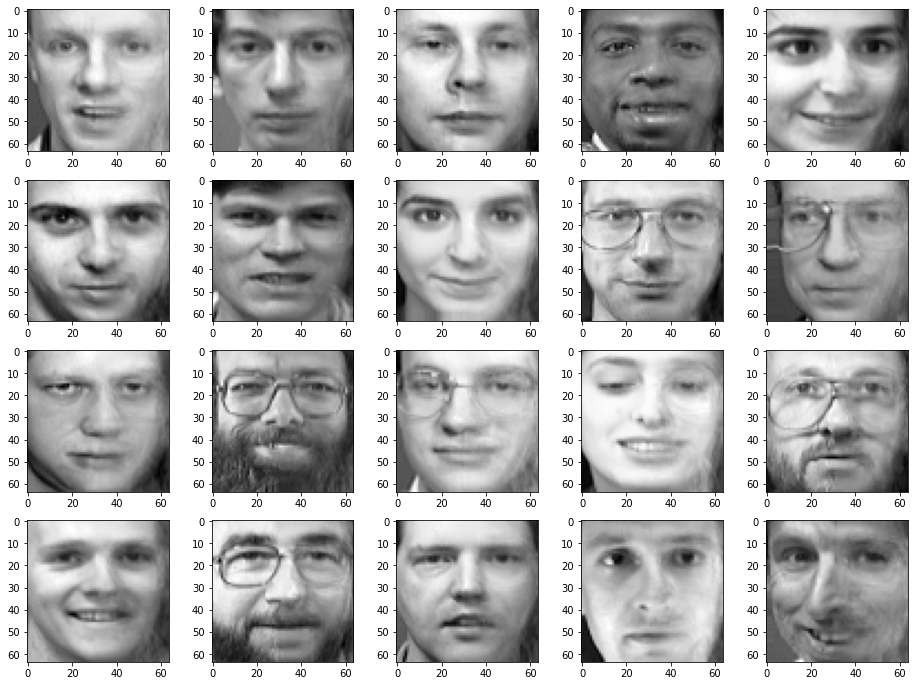

In [28]:
# Test predictions
pics = glue(X_test, gscv_elastic.predict(X_test))
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

---

# Bonus part

Try using `sklearn.linear_model.SGDRegressor` with `huber` loss in the code above instead of `LinearRegression`. Is it better in this case?

In [29]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor
bonus = MultiOutputRegressor(SGDRegressor(loss='huber'), n_jobs=-1)
bonus.fit(X_train, y_train)

MultiOutputRegressor(estimator=SGDRegressor(loss='huber'), n_jobs=-1)

In [30]:
mse_train = mean_squared_error(y_train, bonus.predict(X_train))
mse_test = mean_squared_error(y_test, bonus.predict(X_test))

print(f"Train MSE: {mse_train:.5f}")
print(f"Test MSE: {mse_test:.5f}")

Train MSE: 0.01145
Test MSE: 0.01420


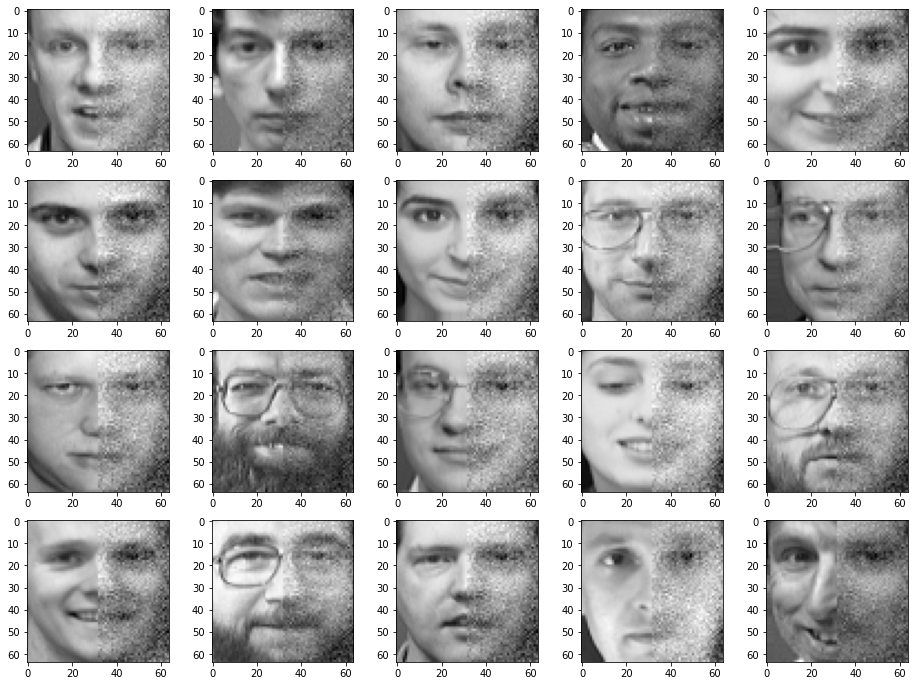

In [31]:
# Test predictions
pics = glue(X_test, bonus.predict(X_test)) # reconstruct and glue together X and Y for the test dataset
plt.figure(figsize=[16, 12])
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(pics[i], cmap='gray')

P.S. This assignment is inspired by [YSDA materials](https://github.com/yandexdataschool).

LinearRegression is better in this case.